- 1. hvor lange tid tage det og ankomme til destination


- 2. Hvor lange tid tage det i genmesnigt for en fire case


- 3. Zipcode Battalion station area


- 4. Suppression Units and Personnel


- 5. Primary Situation


- 6. Action Taken Primary


- 7. Action Taken Primary


- 8. neighborhood_district


- 9. Point for maps


In [40]:
import pandas as pd
df = pd.read_csv("../Fire_Incidents.csv")
df['Incident Date'] = pd.to_datetime(df['Incident Date'])


# Get the data from date 2010-04-01 to 2023-04-01
df = df[(df['Incident Date'] >= '2010-04-01') &
        (df['Incident Date'] <= '2023-04-01')]
df['Incident Time'] = df['Incident Date'].dt.time

# print the number of rows
num_rows = df.shape[0]
#print("The number of rows is:", num_rows)
#print(df.head())

df.drop(df[df['ID'] == 140383810 ].index, axis=0, inplace=True)
df.drop(df[df['ID'] == 140660390 ].index, axis=0, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_27540\2028814244.py:2: DtypeWarning:

Columns (10,12,13,20,29,38,45,46,55,59) have mixed types. Specify dtype option on import or set low_memory=False.



In [41]:
# get just the data from Sf city
df = df[(df['City'] == 'SF') | (df['City'] == 'San Francisco')
        | (df['City'] == 'SAN FRANCISCO')]

# Deleting all unnaseccary columns


In [42]:
# add Situation_by_code
df['focuse_Situation_by_number'] = df['Primary Situation'].str[:3]
#df.head()

In [43]:
call_Situation = df['Primary Situation']
df.dropna(subset=['Primary Situation'], inplace=True)
#print(call_Situation)
len(call_Situation)
ListOfSituation = call_Situation.unique()
#print(ListOfSituation)
# by using unique() fun we can se the diffrenet type of data



In [44]:
Situation_count = call_Situation.value_counts()
# Situation_count.to_csv('Situation_count.csv')
top20 = Situation_count.nlargest(20)  # Get the top 20 most frequent situations
#print(top20)

call_Situation_by_number = df['focuse_Situation_by_number']
Situation_count_by_number =call_Situation_by_number.value_counts()
top20_by_number = Situation_count_by_number.nlargest(20)  # Get the top 20 most frequent situations
#print(top20_by_number)

In [45]:
df['Arrival DtTm'] = pd.to_datetime(df['Arrival DtTm'])
df['Arrival DtTm'] = df['Arrival DtTm']

df['Alarm DtTm'] = pd.to_datetime(df['Alarm DtTm'])
df['Alarm DtTm'] = df['Alarm DtTm']
df['Arrive time_minutes'] = (df['Arrival DtTm'] - df['Alarm DtTm'])
df.head()

,Incident Number,Exposure Number,ID,Address,Incident Date,Call Number,Alarm DtTm,Arrival DtTm,Close DtTm,City,...,Automatic Extinguishing Sytem Type,Automatic Extinguishing Sytem Perfomance,Automatic Extinguishing Sytem Failure Reason,Number of Sprinkler Heads Operating,Supervisor District,neighborhood_district,point,Incident Time,focuse_Situation_by_number,Arrive time_minutes
213988,10030287,0,100302870,1065 Sutter St.,2010-04-08,100980182,2010-04-08 12:55:33,2010-04-08 12:59:15,2010-04-08T13:04:16,SF,...,NaN,NaN,NaN,NaN,3.0,Nob Hill,POINT (-122.417859 37.787975),00:00:00,700,0 days 00:03:42
213989,10028522,0,100285220,49 Geary St.,2010-04-02,100920316,2010-04-02 19:51:28,2010-04-02 19:55:47,2010-04-02T20:03:41,SF,...,NaN,NaN,NaN,NaN,NaN,Financial District/South Beach,POINT (-122.40437143 37.78743162),00:00:00,700,0 days 00:04:19
213990,10028478,0,100284780,19th St. / Mission St.,2010-04-02,100920268,2010-04-02 17:20:11,2010-04-02 17:22:52,2010-04-02T17:38:25,SF,...,NaN,NaN,NaN,NaN,NaN,Mission,POINT (-122.419052 37.758632),00:00:00,324,0 days 00:02:41
213991,10030568,0,100305680,Market St. / 4th St.,2010-04-09,100990156,2010-04-09 12:26:06,2010-04-09 12:29:12,2010-04-09T12:29:50,SF,...,NaN,NaN,NaN,NaN,NaN,Financial District/South Beach,POINT (-122.405833 37.785745),00:00:00,118,0 days 00:03:06
213992,10028355,0,100283550,1200 - Blk Great Hy.,2010-04-02,100920118,2010-04-02 10:29:49,2010-04-02 10:34:59,2010-04-02T10:45:29,SF,...,NaN,NaN,NaN,NaN,NaN,Sunset/Parkside,POINT (-122.5093261 37.76397644),00:00:00,322,0 days 00:05:10


In [46]:
average_arrival_time = df['Arrive time_minutes'].mean()
print("The average arrival time is:", average_arrival_time)


The average arrival time is: 0 days 00:05:10.214072328


In [47]:
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)


# Convert to minutes and add a new column

df = df[df['Battalion'] != 'B99']
avg_arrival_time_by_battalion = df.groupby('Battalion')['Arrive time_minutes'].mean().round(2)

print(avg_arrival_time_by_battalion)


Battalion
B01    4.77
B02    4.80
B03    5.28
B04    4.65
B05    4.78
B06    5.17
B07    5.41
B08    5.80
B09    5.89
B10    5.80
Name: Arrive time_minutes, dtype: float64


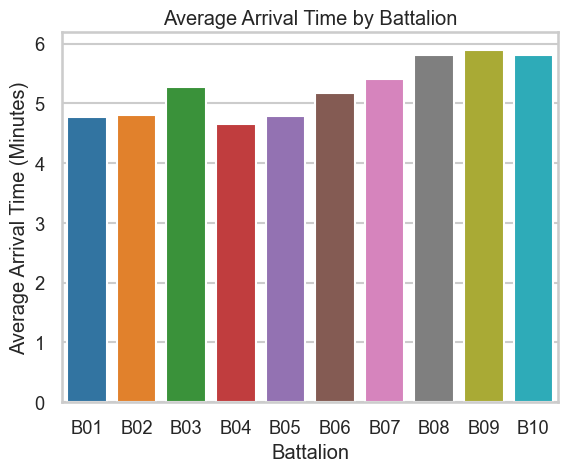

In [48]:
import seaborn as sns

# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)
df = df[df['Battalion'] != 'B99']
avg_arrival_time_by_battalion = df.groupby('Battalion')['Arrive time_minutes'].mean().round(2).reset_index()

# Create a bar chart with seaborn
sns.barplot(x='Battalion', y='Arrive time_minutes', data=avg_arrival_time_by_battalion)

# Add axis labels and title
plt.xlabel('Battalion')
plt.ylabel('Average Arrival Time (Minutes)')
plt.title('Average Arrival Time by Battalion')

# Show the plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


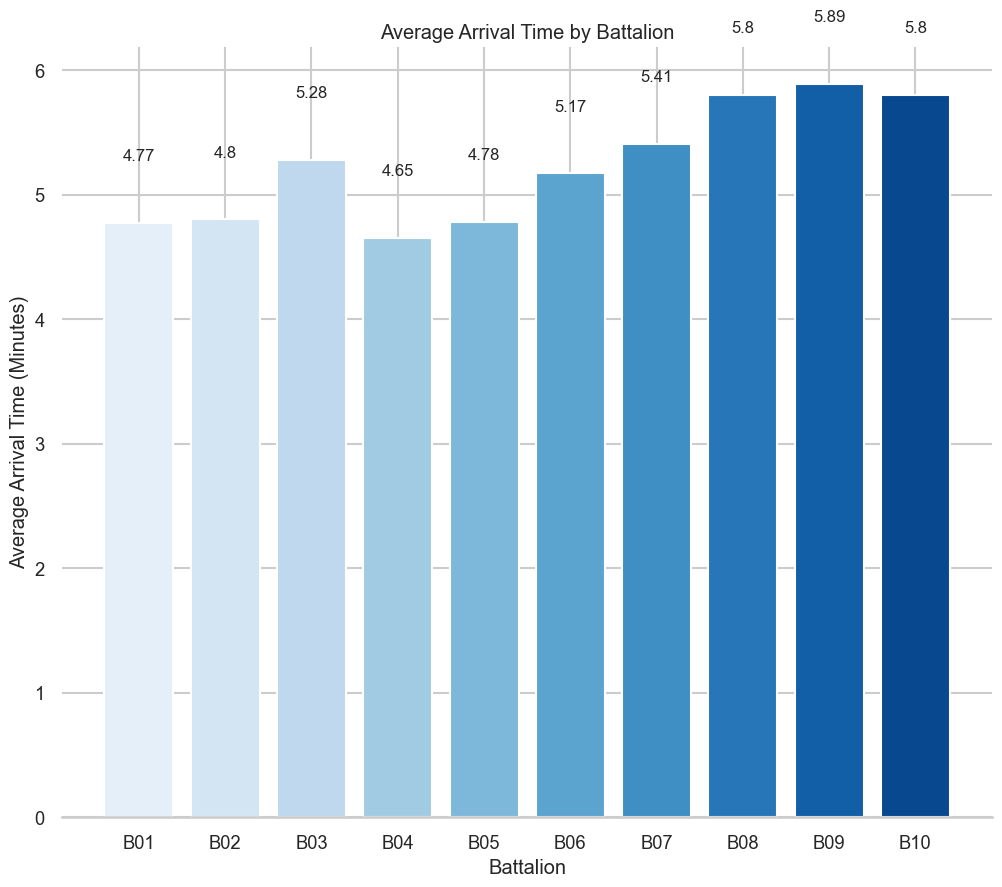

'plot.html'

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as pyo
import plotly.tools as tls

# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)
df = df[df['Battalion'] != 'B99']
avg_arrival_time_by_battalion = df.groupby('Battalion')['Arrive time_minutes'].mean().round(2).reset_index()

# Set style and context for the plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# Create a bar chart with color gradient
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(avg_arrival_time_by_battalion['Battalion'], avg_arrival_time_by_battalion['Arrive time_minutes'], 
       color=sns.color_palette("Blues", n_colors=len(avg_arrival_time_by_battalion)))
ax.set_xlabel('Battalion')
ax.set_ylabel('Average Arrival Time (Minutes)')
ax.set_title('Average Arrival Time by Battalion')

# Add value labels to the bars
for i, v in enumerate(avg_arrival_time_by_battalion['Arrive time_minutes']):
    ax.text(i, v+0.5, str(v), ha='center', fontsize=12)

# Hide spines and add legend
sns.despine(left=True)
ax.legend().set_visible(False)

plt.show()

py_fig = tls.mpl_to_plotly(fig)
pyo.plot(py_fig, filename='plot.html')


<function __main__.<lambda>(sel)>

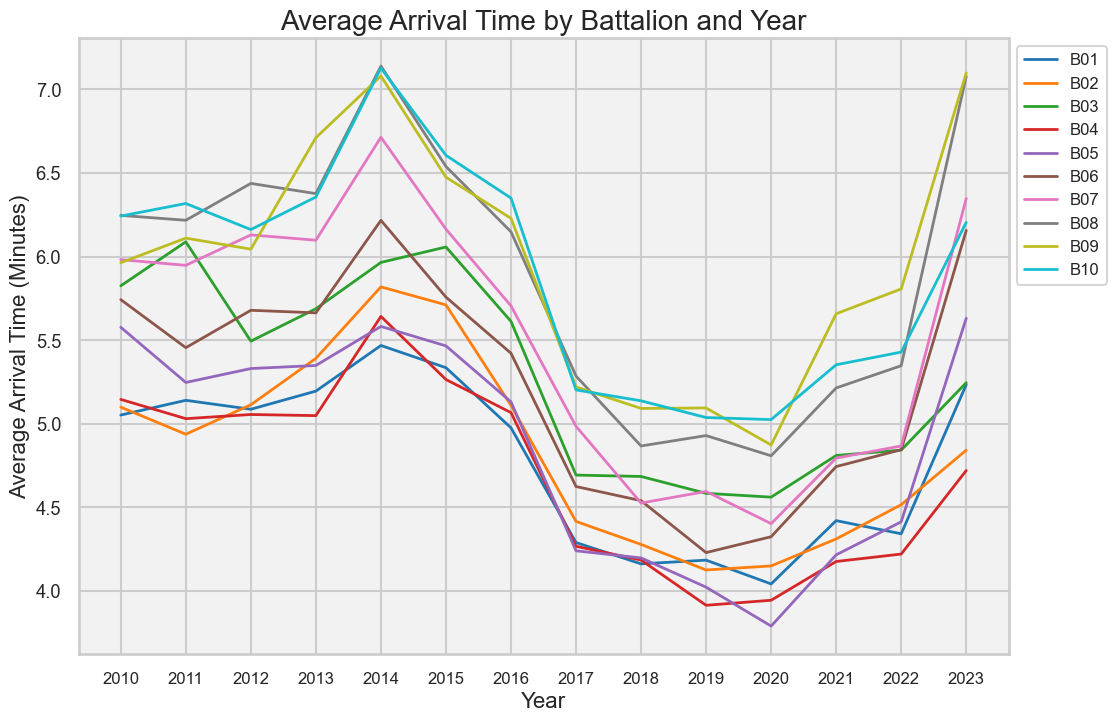

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import plotly.offline as pyo
import plotly.tools as tls


# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)

# Group by battalion and year
df['year'] = df['Incident Date'].dt.year
df_grouped = df.groupby(['Battalion', 'year'])['Arrive time_minutes'].mean().reset_index()


# Set style and context for the plot
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# Create a line plot for each battalion
fig, ax = plt.subplots(figsize=(12,8))
for battalion in df_grouped['Battalion'].unique():
    data = df_grouped[df_grouped['Battalion']==battalion]
    sns.lineplot(x=data['year'], y=data['Arrive time_minutes'], label=battalion, linewidth=2)
   

# Add axis labels and title
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Average Arrival Time (Minutes)', fontsize=16)
ax.set_title('Average Arrival Time by Battalion and Year', fontsize=20)

# Add legend and grid
ax.legend(fontsize=12, bbox_to_anchor=(1, 1))
ax.grid(True)

# Set x-axis ticks to integers and add tick labels for each year
plt.xticks(df_grouped['year'].unique(), df_grouped['year'].unique().astype(int), fontsize=12)

# Add background color to plot area
ax.set_facecolor('#f2f2f2')

# Add interactivity to the plot
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f"{sel.artist.get_label()}\nYear: {int(sel.target[0])}\nAvg. Arrival Time: {sel.target[1]:.2f} minutes"))

# Whith  hovering effects



In [51]:
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
import mplcursors

# Convert to minutes and add a new column
df['Arrive time_minutes'] = ((df['Arrival DtTm'] - df['Alarm DtTm']).dt.total_seconds() / 60.0).round(2)

# Group by battalion and year
df['year'] = df['Incident Date'].dt.year
df_grouped = df.groupby(['Battalion', 'year'])['Arrive time_minutes'].mean().reset_index()

# Create a line plot for each battalion using Plotly
fig = go.Figure()
for battalion in df_grouped['Battalion'].unique():
    data = df_grouped[df_grouped['Battalion'] == battalion]
    fig.add_trace(go.Scatter(x=data['year'], y=data['Arrive time_minutes'], name=battalion, line=dict(width=2)))

# Set layout for the plot
fig.update_layout(
    title="Average Arrival Time by Battalion and Year",
    xaxis_title="Year",
    yaxis_title="Average Arrival Time (Minutes)",
    font=dict(
        family="Arial",
        size=16,
        color="#7f7f7f"
    ),
    legend=dict(
        title="Battalion",
        font=dict(
            family="Arial",
            size=12,
            color="#7f7f7f"
        ),
        yanchor="top",
        y=1,
        xanchor="right",
        x=1
    ),
    plot_bgcolor="#f2f2f2",
    xaxis=dict(
        tickmode='linear',
        tick0=2003,
        dtick=1
    )
)


# Add interactivity to the plot using mplcursors
annotations = [f"{battalion}\nYear: {int(data['year'])}\nAvg. Arrival Time: {data['Arrive time_minutes']:.2f} minutes"
               for battalion, data in df_grouped[['Battalion', 'year', 'Arrive time_minutes']].iterrows()]
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(annotations[sel.target.index]))

# Save the plot to an HTML file and display it in the browser
pyo.plot(fig, filename='battalion_arrival_time.html', auto_open=True)


'battalion_arrival_time.html'